In [1]:
import numpy as np
import pandas as pd
from pymc_extras.statespace.models import structural as st

import pymc as pm
import arviz as az
import pytensor.tensor as pt

import matplotlib.pyplot as plt

In [2]:
rng = np.random

In [3]:
def simulate_local_level_with_exog(
    n_endog: int = 1,
    time_steps: int = 100,
    mu0: float = 0.0,
    sigma_eta: float = 1.0,
    sigma_eps: float = 0.5,
    beta1: float = 2.0,
    beta2: float = -1.5,
    seed: int | None = None,
):
    """
    Simulates a local level model with exogenous variables.

    Parameters
    ----------
    n_endog: int
        The number of series to simulate
    time_steps: int
        The length of the time-series to simulate
    mu0: float
        The initial state
    sigma_eta: float
        The level innovations standard deviation
    sigma_eps: float
        The observations standard deviation
    beta1: float
        The weight of the binary exogenous variable
    beta2: float
        The weight of the continuous exogenous variable
    seed: int
        Random generator seed for reproducibility

    Returns
    -------
    ys: dict[str, float]
        n_endog number of observations
    mu: float
        latent state
    x1: int
        binary exogenous observations
    x2: float
        continuous exogenous observations
    """
    if seed is not None:
        np.random.seed(seed)

    # init state and observation vectors
    mu = np.zeros(time_steps)
    y = np.zeros(time_steps)

    # initial state
    mu[0] = mu0

    # simulate exogenous variables
    # binary variable
    x1 = np.random.binomial(1, 0.2, size=time_steps)

    # continous variable
    x2 = np.random.normal(0, 1, size=time_steps)

    # simulate latent state (local level)
    for t in range(1, time_steps):
        mu[t] = mu[t - 1] + np.random.normal(0, sigma_eta)

    # simulate observations
    ys = {
        f"y{i+1}": mu + beta1 * x1 + beta2 * x2 + np.random.normal(0, sigma_eps, size=time_steps)
        for i in range(n_endog)
    }

    return ys, mu, x1, x2

In [4]:
# Simulate
T = 100
true_sigma_eta = 0.3
true_sigma_eps = 0.6
true_beta1 = 3.0
true_beta2 = -1.0
ys, mu, x1, x2 = simulate_local_level_with_exog(
    n_endog=3,
    time_steps=T,
    mu0=0,
    sigma_eta=true_sigma_eta,
    sigma_eps=true_sigma_eps,
    beta1=true_beta1,
    beta2=true_beta2,
    seed=42,
)

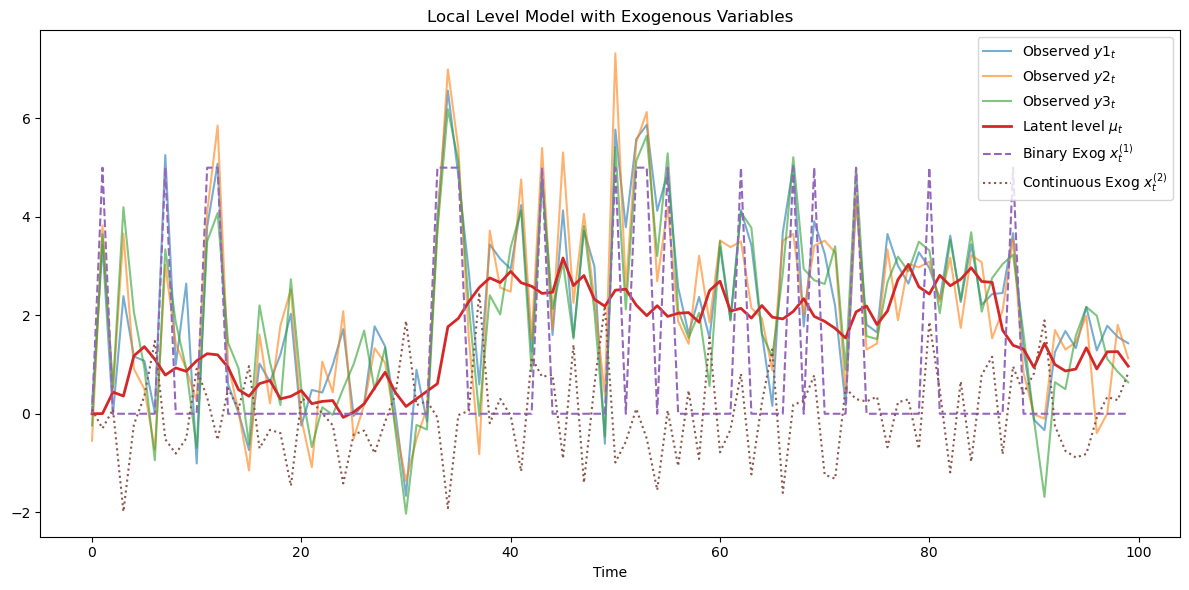

In [5]:
y = ys["y1"]

# Plot
plt.figure(figsize=(12, 6))
for k, vy in ys.items():
    plt.plot(vy, label=f"Observed ${k}_t$", alpha=0.6)
plt.plot(mu, label="Latent level $\\mu_t$", linewidth=2)
plt.plot(x1 * 5, label="Binary Exog $x^{(1)}_t$", linestyle="--")  # need to blow up to see it
plt.plot(x2, label="Continuous Exog $x^{(2)}_t$", linestyle=":")
plt.legend()
plt.title("Local Level Model with Exogenous Variables")
plt.xlabel("Time")
plt.tight_layout()
plt.show()

# Quick and dirty test

In [6]:
level_trend = st.LevelTrendComponent(
    order=1, innovations_order=[1], name="level_trend", observed_state_names=["y1", "y2", "y3"]
)

exog = st.RegressionComponent(
    name="exog",
    k_exog=2,
    innovations=False,
    state_names=["x1", "x2"],
    observed_state_names=["y1", "y2", "y3"],
)

ss_mod = (level_trend + exog).build(mode="JAX")

                                           Model Requirements                                            
                                                                                                         
  Variable              Shape       Constraints                                              Dimensions  
 ─────────────────────────────────────────────────────────────────────────────────────────────────────── 
  initial_level_trend   (3, 1)                               ('endog_level_trend', 'state_level_trend')  
  sigma_level_trend     (3, 1)      Positive                 ('endog_level_trend', 'level_trend_shock')  
  beta_exog             (3, 2)                                             ('endog_exog', 'state_exog')  
  P0                    (9, 9)      Positive semi-definite                       ('state', 'state_aux')  
                                                                                                         
  data_exog             (None, 2)   pm.Data                                      ('time', 'state_exog')  
                                                                                                         
         These parameters should be assigned priors inside a PyMC model block before calling the         
                                     build_statespace_graph method.                                      

In [21]:
with pm.Model(coords=ss_mod.coords) as level_trend_exog_model:
    # Data container
    data_exog = pm.Data(
        name=ss_mod.data_names[0],
        value=np.vstack((x1, x2)).T,
        dims=ss_mod.data_info[ss_mod.data_names[0]]["dims"],
    )

    # Initial local level trend
    initial_trend = pm.Normal(
        name=ss_mod.param_names[0], mu=0, sigma=1, dims=ss_mod.param_dims[ss_mod.param_names[0]]
    )

    # Local level innovations sigma
    sigma_trend = pm.HalfNormal(
        name=ss_mod.param_names[1], sigma=1, dims=ss_mod.param_dims[ss_mod.param_names[1]]
    )

    # exogenous variable parameter priors
    beta_exog = pm.Normal(
        name=ss_mod.param_names[2], mu=0, sigma=5, dims=ss_mod.param_dims[ss_mod.param_names[2]]
    )

    # Initial process covariance matrix
    P0_diag = pm.Gamma("P0_diag", alpha=2, beta=4, dims="state")
    P0 = pm.Deterministic(
        name=ss_mod.param_names[3],
        var=pt.diag(P0_diag),
        dims=ss_mod.param_dims[ss_mod.param_names[3]],
    )

    ss_mod.build_statespace_graph(np.vstack((ys["y1"], ys["y2"], ys["y3"])).T)

/Users/dekermanjian/Desktop/Open_Source_Contributions/pymc-extras/pymc_extras/statespace/utils/data_tools.py:74: UserWarning: No time index found on the supplied data. A simple range index will be automatically generated.
  warnings.warn(NO_TIME_INDEX_WARNING)


In [12]:
with level_trend_exog_model:
    idata = pm.sample(
        nuts_sampler="nutpie", nuts_sampler_kwargs={"backend": "JAX", "gradient_backend": "JAX"}
    )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,18,0.54,7
,2000,8,0.51,15
,2000,11,0.54,7
,2000,3,0.51,7


In [16]:
az.summary(idata, var_names=["beta_exog", "sigma_level_trend"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta_exog[y1, x1]",2.937,0.730,1.454,4.245,0.013,0.015,3301.0,2069.0,1.0
"beta_exog[y1, x2]",-1.021,0.681,-2.262,0.359,0.012,0.013,3498.0,2804.0,1.0
"beta_exog[y2, x1]",2.993,0.707,1.682,4.361,0.012,0.013,3819.0,2440.0,1.0
"beta_exog[y2, x2]",-1.065,0.722,-2.429,0.357,0.013,0.016,3270.0,2700.0,1.0
"beta_exog[y3, x1]",2.787,0.703,1.382,4.130,0.012,0.013,3308.0,2418.0,1.0
"beta_exog[y3, x2]",-0.926,0.714,-2.250,0.422,0.013,0.014,3395.0,2747.0,1.0
"sigma_level_trend[y1, level]",0.755,0.055,0.648,0.853,0.001,0.001,6063.0,2759.0,1.0
"sigma_level_trend[y2, level]",0.926,0.066,0.809,1.053,0.001,0.001,6809.0,2781.0,1.0
"sigma_level_trend[y3, level]",0.848,0.063,0.734,0.968,0.001,0.001,5920.0,2583.0,1.0


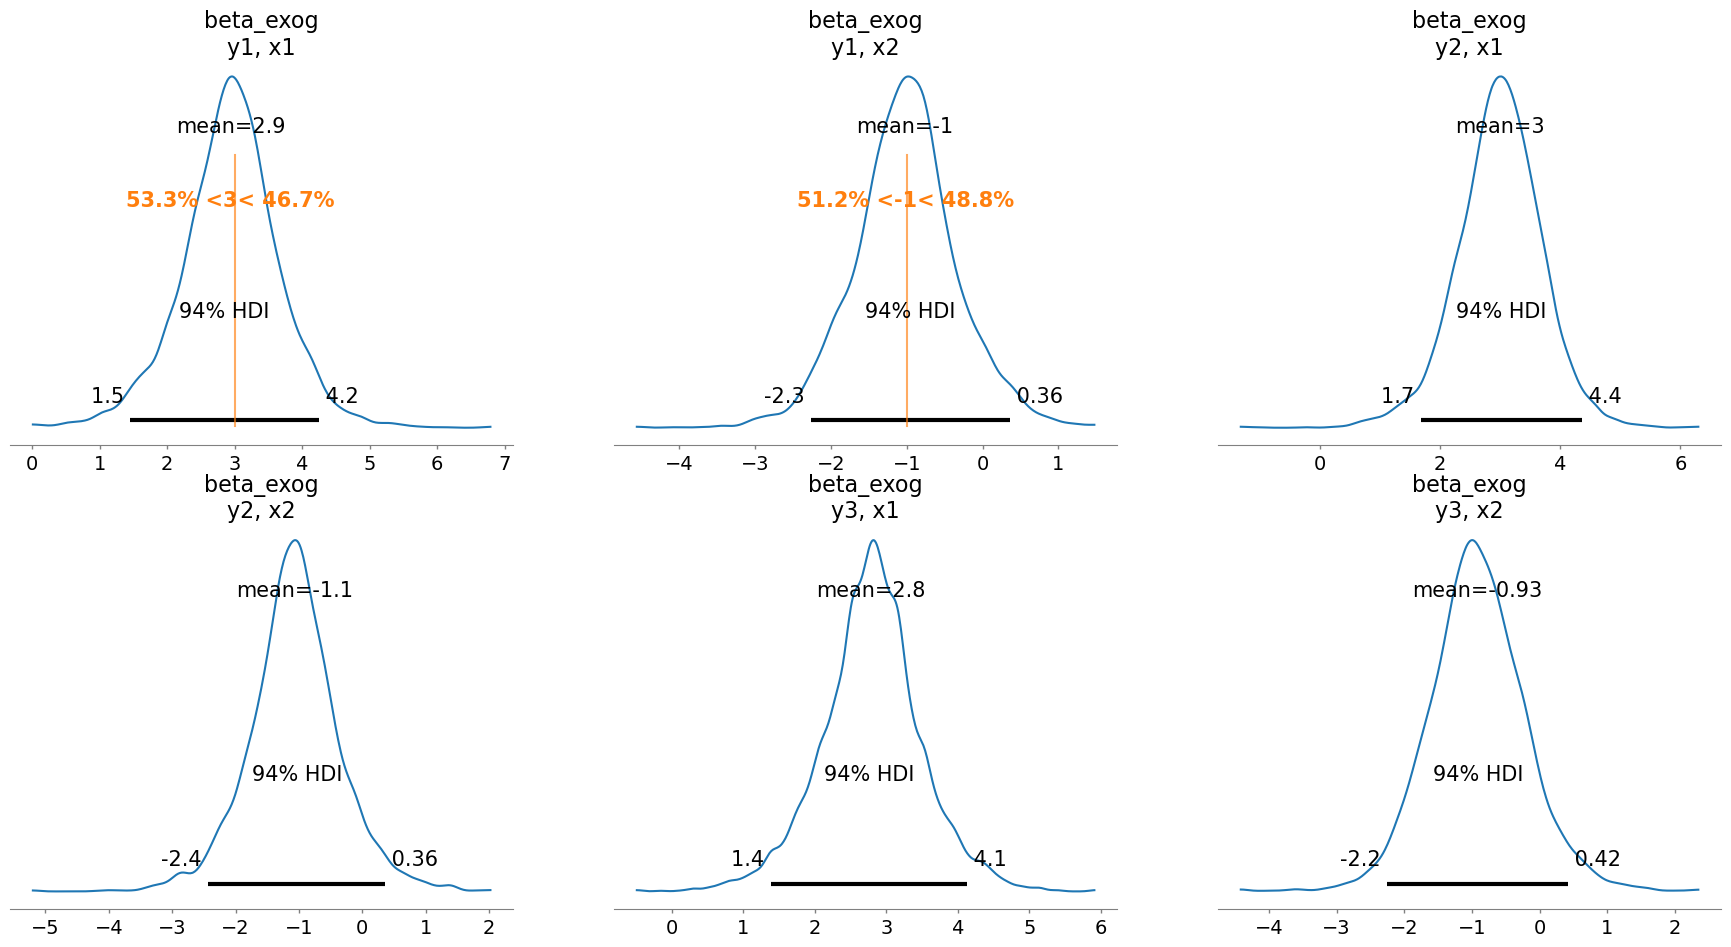

In [17]:
az.plot_posterior(
    idata,
    var_names="beta_exog",
    ref_val={
        "beta_exog": [
            {"endog_exog": "y1", "state_exog": "x1", "ref_val": true_beta1},
            {"endog_exog": "y1", "state_exog": "x2", "ref_val": true_beta2},
        ]
    },
);

In [18]:
idata_forecast = ss_mod.forecast(idata=idata, periods=10, scenario=np.vstack((x1, x2)).T[-10:])

No start date provided. Using the last date in the data index. To silence this warning, explicitly pass a start date or set verbose = False
/Users/dekermanjian/Desktop/Open_Source_Contributions/pymc-extras/pymc_extras/statespace/utils/data_tools.py:74: UserWarning: No time index found on the supplied data. A simple range index will be automatically generated.
  warnings.warn(NO_TIME_INDEX_WARNING)
/opt/miniconda3/envs/pymc-extras-test/lib/python3.12/site-packages/pytensor/link/jax/linker.py:32: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x35C46D380>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [forecast_combined]


Output()

In [19]:
y1_forecast = idata_forecast.forecast_observed.sel(observed_state="y1")

In [20]:
y1_hdi = az.hdi(idata_forecast.forecast_observed.sel(observed_state="y1"))

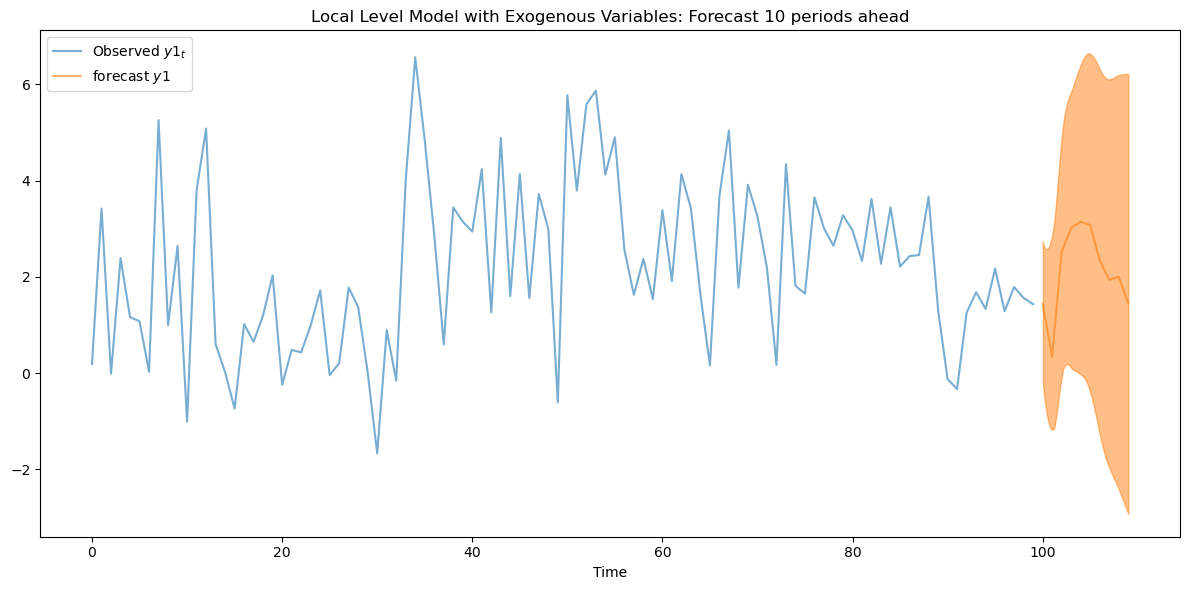

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(ys["y1"], label=f"Observed $y1_t$", alpha=0.6)
az.plot_hdi(x=np.arange(100, 110), hdi_data=y1_hdi)
plt.plot(
    np.arange(100, 110), y1_forecast.mean(("chain", "draw")), label=f"forecast $y1$", alpha=0.6
)

plt.legend()
plt.title("Local Level Model with Exogenous Variables: Forecast 10 periods ahead")
plt.xlabel("Time")
plt.tight_layout()
plt.show()

# Need to test with missing data

In [22]:
def impose_missingness(
    X: np.ndarray,
    total_missing_percent: float = 0.2,
    mcar_ratio: float = 0.33,
    mar_ratio: float = 0.33,
    mnar_ratio: float = 0.34,
    mar_features: list | None = None,
    mnar_features: list | None = None,
    seed: int | None = None,
):
    """
    Imposes missingness according to specified missing mechanisms MCAR, MAR, and MNAR

    Parameters
    ----------
    X: np.ndarray
        The matrix to impose missingness into
    total_missing_percent: float
        The percentage of total missingness to impose
    mcar_ratio: float
        The ratio of MCAR missingness to impose
    mar_ratio: float
        The ration of MAR missingness to impose
    mnar_ratio: float
        The ratio of MNAR missingness to impose
    mar_features: list|None
        The column index of the MAR features to condition on
    mnar_features: list|None
        The column index of the MNAR features to impose MNAR missingness
    seed: int|None
        The seed for reproducibility

    Returns
    -------
    X_missing: np.ndarray
        The original matrix with imposed missingness
    missing_mask: np.ndarray
        The missing mask that corresponds to the imposed missing values
    """
    if mar_features is None and mar_ratio != 0.0:
        raise ValueError(
            "If you want to impose MAR missing values you must set the index of the MAR variable(s) using `mar_features` otherwise set `mar_ratio = 0`"
        )

    if mar_features and mar_ratio == 0.0:
        raise ValueError("Pass `mar_features=None` if you do not wish to impose MAR missingness.")

    if mnar_features is None and mnar_ratio != 0.0:
        raise ValueError(
            "If you want to impose MNAR missing values you must set the index of the MNAR variable(s) using `mnar_features` otherwise set `mnar_ratio = 0`"
        )

    if mnar_features and mnar_ratio == 0.0:
        raise ValueError("Pass `mnar_features=None` if you do not wish to impose MNAR missingness.")

    assert np.isclose(mcar_ratio + mar_ratio + mnar_ratio, 1.0), "Ratios must sum to 1"

    rng = np.random.default_rng(seed)
    X_missing = X.copy()
    n_rows, n_cols = X.shape
    total_cells = n_rows * n_cols
    n_missing = int(total_cells * total_missing_percent)

    # Number of missing cells by type
    n_mcar = int(n_missing * mcar_ratio)
    n_mar = int(n_missing * mar_ratio)
    n_mnar = n_missing - n_mcar - n_mar  # ensures total = n_missing

    missing_mask = np.zeros_like(X_missing, dtype=bool)

    # --- MCAR: Randomly pick cells to be missing
    all_indices = np.argwhere(~missing_mask)
    mcar_indices = all_indices[rng.choice(len(all_indices), size=n_mcar, replace=False)]
    for i, j in mcar_indices:
        missing_mask[i, j] = True

    # --- MAR: Missingness in other columns depending on mar_features
    if mar_features:
        mar_features = list(mar_features)
        mar_cond_scores = np.zeros(n_rows)
        for f in mar_features:
            col = X[:, f]
            norm_col = (col - np.min(col)) / (np.max(col) - np.min(col) + 1e-16)
            mar_cond_scores += norm_col
        mar_probs = mar_cond_scores / (mar_cond_scores.sum() + 1e-16)

        mar_rows = rng.choice(n_rows, size=n_mar, p=mar_probs, replace=True)
        mar_cols = rng.choice([c for c in range(n_cols) if c not in mar_features], size=n_mar)
        for i, j in zip(mar_rows, mar_cols):
            missing_mask[i, j] = True

    # --- MNAR: Missing values depend on values in the same columns set by mnar_features
    if mnar_features:
        mnar_features = list(mnar_features)
        mnar_rows_all = []
        mnar_cols_all = []
        n_mnar_per_feature = n_mnar // len(mnar_features)
        for f in mnar_features:
            col = X[:, f]
            norm_col = (col - np.min(col)) / (np.max(col) - np.min(col) + 1e-16)
            mnar_probs = norm_col / (norm_col.sum() + 1e-16)
            mnar_rows = rng.choice(n_rows, size=n_mnar_per_feature, p=mnar_probs, replace=True)
            mnar_rows_all.extend(mnar_rows)
            mnar_cols_all.extend([f] * n_mnar_per_feature)

        # Adjust if rounding caused mismatch
        while len(mnar_rows_all) < n_mnar:
            mnar_rows_all.append(rng.integers(0, n_rows))
            mnar_cols_all.append(mnar_features[0])

        for i, j in zip(mnar_rows_all, mnar_cols_all):
            missing_mask[i, j] = True

    # Apply mask
    X_missing[missing_mask] = np.nan
    return X_missing, missing_mask

In [23]:
X = np.vstack((x1, x2, ys["y1"], ys["y2"], ys["y3"])).T

In [24]:
X_miss, mask = impose_missingness(
    X,
    total_missing_percent=0.2,
    mcar_ratio=0.3,
    mar_ratio=0.4,
    mnar_ratio=0.3,
    mar_features=[
        0,
    ],
    mnar_features=[
        2,
    ],
    seed=31324,
)

print("Missing values introduced:", np.isnan(X_miss).sum())

Missing values introduced: 79


In [25]:
level_trend = st.LevelTrendComponent(
    order=1, innovations_order=[1], name="level_trend", observed_state_names=["y1", "y2", "y3"]
)

exog = st.RegressionComponent(
    name="exog",
    k_exog=2,
    innovations=False,
    state_names=["x1", "x2"],
    observed_state_names=["y1", "y2", "y3"],
)

ss_mod = (level_trend + exog).build(mode="JAX")

                                           Model Requirements                                            
                                                                                                         
  Variable              Shape       Constraints                                              Dimensions  
 ─────────────────────────────────────────────────────────────────────────────────────────────────────── 
  initial_level_trend   (3, 1)                               ('endog_level_trend', 'state_level_trend')  
  sigma_level_trend     (3, 1)      Positive                 ('endog_level_trend', 'level_trend_shock')  
  beta_exog             (3, 2)                                             ('endog_exog', 'state_exog')  
  P0                    (9, 9)      Positive semi-definite                       ('state', 'state_aux')  
                                                                                                         
  data_exog             (None, 2)   pm.Data                                      ('time', 'state_exog')  
                                                                                                         
         These parameters should be assigned priors inside a PyMC model block before calling the         
                                     build_statespace_graph method.                                      

## Need to make some adjustments to state space to allow passing of pm.Deterministic exogenous variables. Or take a 2 model approach

In [26]:
with pm.Model() as imputation_model:
    x1_imp = pm.Bernoulli(
        "x1_imp",
        p=np.where(np.isnan(X_miss[:, 0]), np.nanmean(X_miss[:, 0]), X_miss[:, 0]),
        observed=X_miss[:, 0],
    )

    sigma_x2_imp = pm.HalfNormal("sigma_x2_imp", 0.5)

    alpha_x2_imp = pm.Normal("alpha_x2_imp", np.nanmean(X_miss[:, 1]), 0.5)
    beta_x1_imp = pm.Normal("beta_x1_imp", 0, 0.5)

    x2_imp_mean = pm.Deterministic("x2_imp_mean", alpha_x2_imp + beta_x1_imp * x1_imp)

    x2_imp = pm.Normal("x2_imp", x2_imp_mean, sigma_x2_imp, observed=X_miss[:, 1])

/opt/miniconda3/envs/pymc-extras-test/lib/python3.12/site-packages/pymc/model/core.py:1295: RuntimeWarning: invalid value encountered in cast
  data = convert_observed_data(data).astype(rv_var.dtype)
/opt/miniconda3/envs/pymc-extras-test/lib/python3.12/site-packages/pymc/model/core.py:1309: ImputationWarning: Data in x1_imp contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/opt/miniconda3/envs/pymc-extras-test/lib/python3.12/site-packages/pymc/model/core.py:1309: ImputationWarning: Data in x2_imp contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [27]:
with imputation_model:
    idata_impute = pm.sample()
    idata_impute.extend(pm.sample_posterior_predictive(idata_impute))

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [x1_imp_unobserved]
>NUTS: [sigma_x2_imp, alpha_x2_imp, beta_x1_imp, x2_imp_unobserved]
/opt/miniconda3/envs/pymc-extras-test/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/opt/miniconda3/envs/pymc-extras-test/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [x1_imp_observed, x2_imp_observed, x2_imp_unobserved]


Output()

In [28]:
from scipy.stats import mode

In [29]:
x1_imputed, _ = mode(idata_impute.posterior_predictive["x1_imp"], axis=(0, 1))

In [30]:
x2_imputed = idata_impute.posterior_predictive["x2_imp"].mean(("chain", "draw")).values

In [31]:
with pm.Model(coords=ss_mod.coords) as level_trend_exog_model:
    # Data container
    data_exog = pm.Data(
        "data_exog", np.vstack((x1_imputed, x2_imputed)).T, dims=("time", "state_exog")
    )

    # Initial process covariance matrix
    P0_diag = pm.Gamma("P0_diag", alpha=2, beta=4, dims="state")
    P0 = pm.Deterministic("P0", pt.diag(P0_diag), dims=("state", "state_aux"))

    # Initial local level trend
    initial_trend = pm.Normal(
        "initial_level_trend", mu=0, sigma=1, dims=("endog_level_trend", "state_level_trend")
    )

    # Local level innovations sigma
    sigma_trend = pm.HalfNormal(
        "sigma_level_trend", 1, dims=("endog_level_trend", "level_trend_shock")
    )

    # exogenous variable parameter priors
    beta_exog = pm.Normal("beta_exog", 0, 5, dims=("endog_exog", "state_exog"))

    ss_mod.build_statespace_graph(X_miss[:, 2:])

/Users/dekermanjian/Desktop/Open_Source_Contributions/pymc-extras/pymc_extras/statespace/utils/data_tools.py:74: UserWarning: No time index found on the supplied data. A simple range index will be automatically generated.
  warnings.warn(NO_TIME_INDEX_WARNING)
/Users/dekermanjian/Desktop/Open_Source_Contributions/pymc-extras/pymc_extras/statespace/utils/data_tools.py:174: ImputationWarning: Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering.
  warnings.warn(impute_message, ImputationWarning)


In [32]:
with level_trend_exog_model:
    idata = pm.sample(
        nuts_sampler="nutpie", nuts_sampler_kwargs={"backend": "JAX", "gradient_backend": "JAX"}
    )

/opt/miniconda3/envs/pymc-extras-test/lib/python3.12/functools.py:912: UserWarning: Skipping `CheckAndRaise` Op (assertion: PyTensor Assert failed!) as JAX tracing would remove it.
  return dispatch(args[0].__class__)(*args, **kw)


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,6,0.57,7
,2000,10,0.55,7
,2000,9,0.57,7
,2000,8,0.59,7


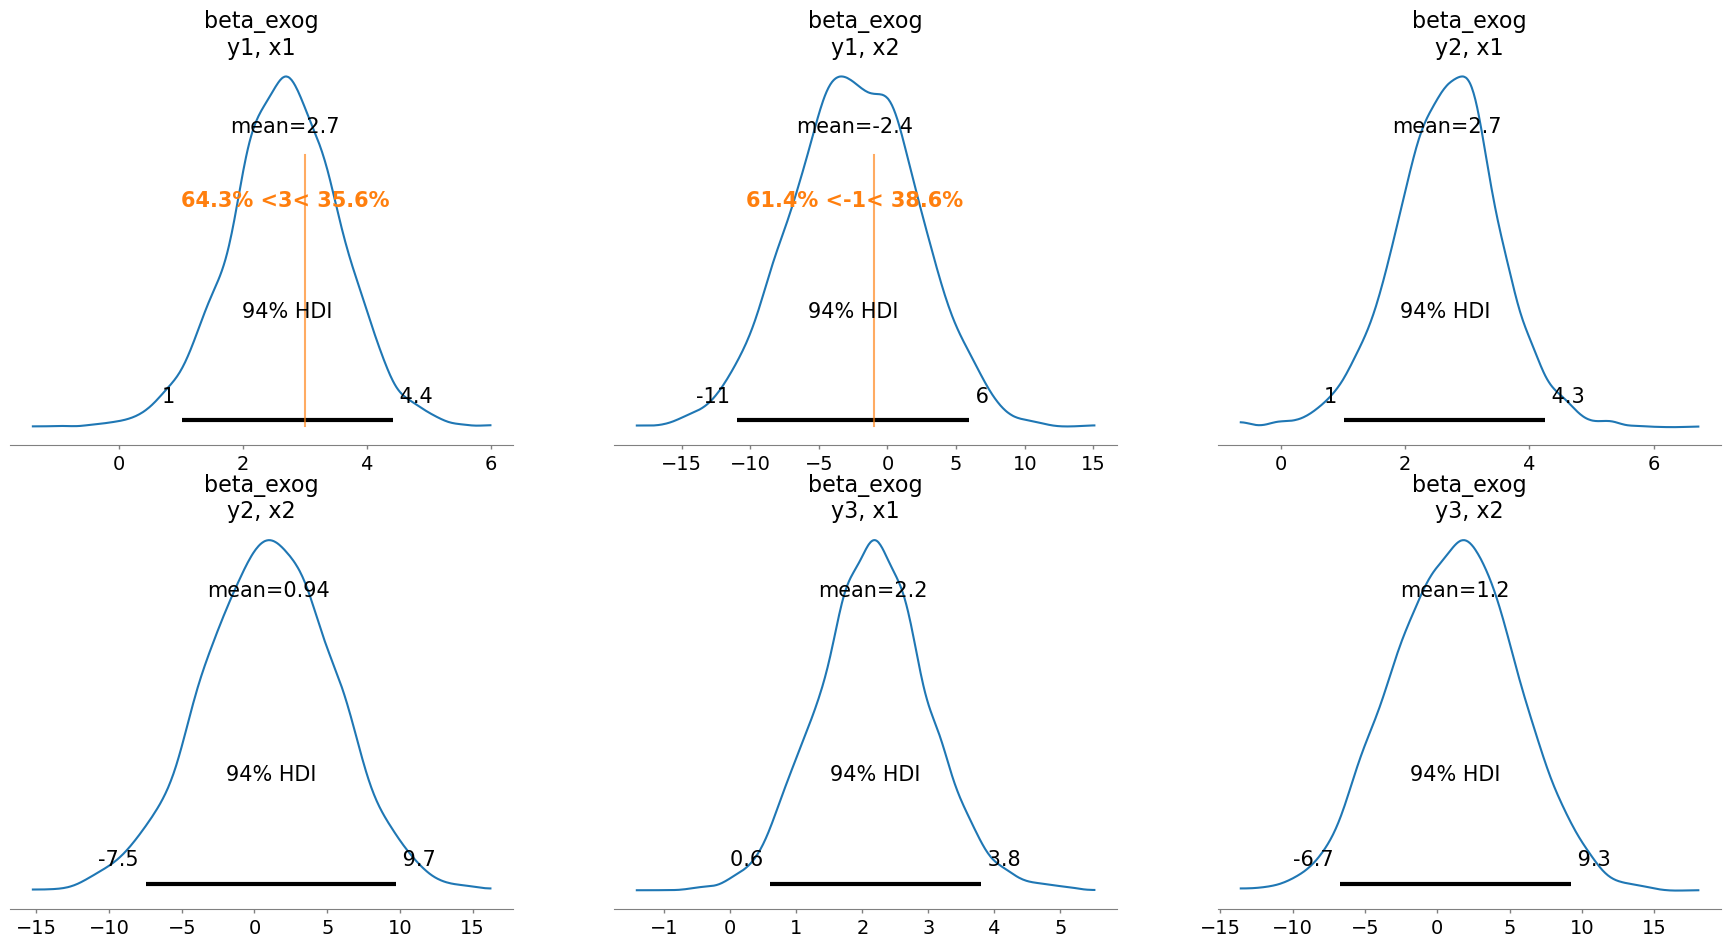

In [34]:
az.plot_posterior(
    idata,
    var_names="beta_exog",
    ref_val={
        "beta_exog": [
            {"endog_exog": "y1", "state_exog": "x1", "ref_val": true_beta1},
            {"endog_exog": "y1", "state_exog": "x2", "ref_val": true_beta2},
        ]
    },
);

In [35]:
idata_forecast = ss_mod.forecast(
    idata=idata, periods=10, scenario=np.vstack((x1_imputed, x2_imputed)).T[-10:]
)

No start date provided. Using the last date in the data index. To silence this warning, explicitly pass a start date or set verbose = False
/Users/dekermanjian/Desktop/Open_Source_Contributions/pymc-extras/pymc_extras/statespace/utils/data_tools.py:74: UserWarning: No time index found on the supplied data. A simple range index will be automatically generated.
  warnings.warn(NO_TIME_INDEX_WARNING)
/Users/dekermanjian/Desktop/Open_Source_Contributions/pymc-extras/pymc_extras/statespace/utils/data_tools.py:174: ImputationWarning: Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering.
  warnings.warn(impute_message, ImputationWarning)
/opt/miniconda3/envs/pymc-extras-test/lib/python3.12/site-packages/pytensor/link/jax/linker.py:32: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x35CE27AE0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
/opt/miniconda3/envs/pymc-e

Output()

In [36]:
y1_forecast = idata_forecast.forecast_observed.sel(observed_state="y1")
y1_hdi = az.hdi(idata_forecast.forecast_observed.sel(observed_state="y1"))

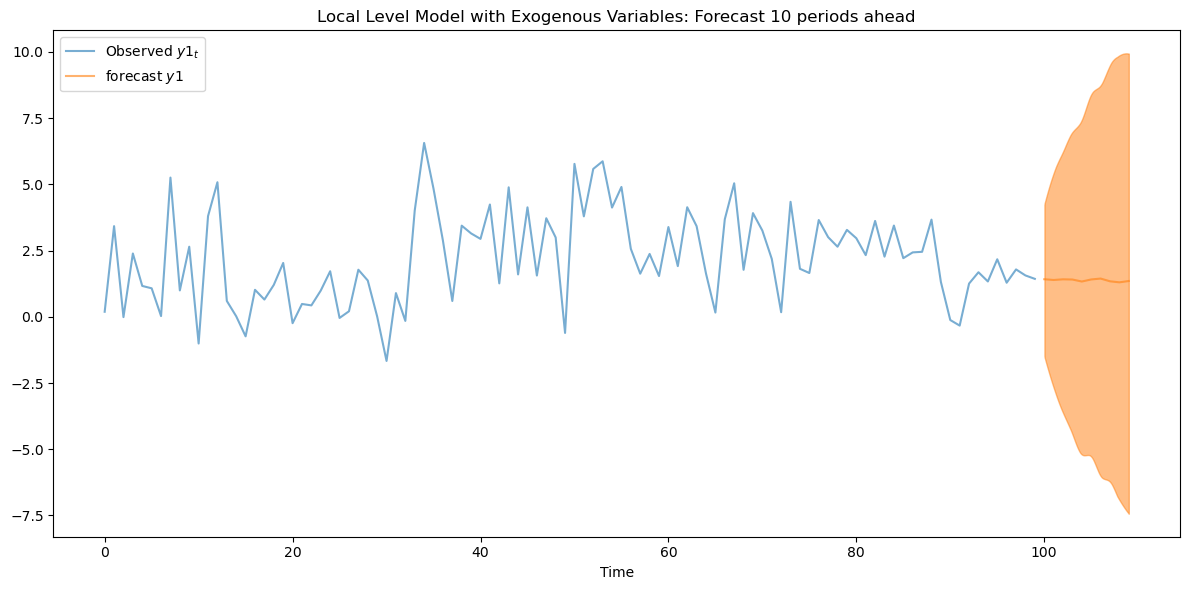

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(ys["y1"], label=f"Observed $y1_t$", alpha=0.6)
az.plot_hdi(x=np.arange(100, 110), hdi_data=y1_hdi)
plt.plot(
    np.arange(100, 110), y1_forecast.mean(("chain", "draw")), label=f"forecast $y1$", alpha=0.6
)

plt.legend()
plt.title("Local Level Model with Exogenous Variables: Forecast 10 periods ahead")
plt.xlabel("Time")
plt.tight_layout()
plt.show()

# Pull pieces from above to make simple regression component tests. 

In [32]:
state_names = pd.date_range("1900-01-01", "1900-12-31", freq="MS").month_name().tolist()

In [4]:
n_periods = 120  # 10 years of monthly data
dates = pd.date_range("2014-01-01", periods=n_periods, freq="MS")

In [5]:
# True parameters for 3 economic indicators
trend_drifts = [0.05, -0.02, 0.01]  # GDP growth, unemployment, inflation
seasonal_patterns = [
    np.array([1.5, 1.0, 0.5, 0.0, -0.5, -1.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0]),  # GDP seasonality
    np.array([-0.5, -0.3, -0.1, 0.1, 0.3, 0.5, 0.3, 0.1, -0.1, -0.3, -0.5, -0.3]),  # Unemployment
    np.array([0.2, 0.1, 0.0, -0.1, -0.2, -0.1, 0.0, 0.1, 0.2, 0.1, 0.0, -0.1]),  # Inflation
]

data = np.zeros((n_periods, 3))
for i in range(3):
    trend = np.cumsum(np.random.normal(trend_drifts[i], 0.05, n_periods))
    seasonal = np.tile(seasonal_patterns[i], n_periods // 12 + 1)[:n_periods]
    noise = np.random.normal(0, 0.3, n_periods)
    data[:, i] = trend + seasonal + noise

df = pd.DataFrame(data, index=dates, columns=["gdp", "unemployment", "inflation"])

state_names = pd.date_range("1900-01-01", "1900-12-31", freq="MS").month_name().tolist()

                                           Model Requirements                                           
                                                                                                        
  Variable              Shape      Constraints                                              Dimensions  
 ────────────────────────────────────────────────────────────────────────────────────────────────────── 
  initial_level_trend   (3, 1)                              ('endog_level_trend', 'state_level_trend')  
  sigma_level_trend     (3, 1)     Positive                 ('endog_level_trend', 'level_trend_shock')  
  annual_coefs          (3, 11)                                       ('annual_endog', 'annual_state')  
  P0                    (36, 36)   Positive semi-definite                       ('state', 'state_aux')  
                                                                                                        
        These parameters should be assigned priors inside a PyMC model block before calling the         
                                     build_statespace_graph method.                                     

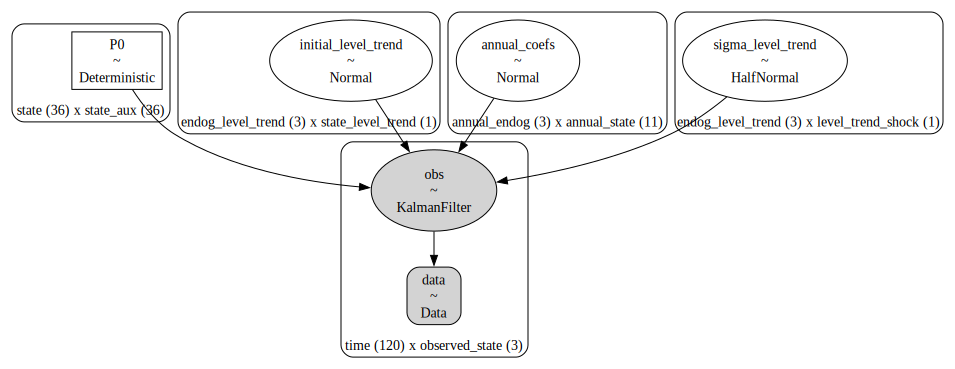

In [6]:
grw = st.LevelTrendComponent(
    order=1, innovations_order=1, observed_state_names=["gdp", "unemployment", "inflation"]
)
annual_season = st.TimeSeasonality(
    season_length=12,
    name="annual",
    state_names=state_names,
    innovations=False,
    observed_state_names=["gdp", "unemployment", "inflation"],
)
ss_mod = (grw + annual_season).build(mode="JAX")

with pm.Model(coords=ss_mod.coords) as model:
    P0 = pm.Deterministic("P0", pt.eye(ss_mod.k_states) * 10, dims=ss_mod.param_dims["P0"])

    # Initial trend states: shape (3, 1) for 3 variables, 1 trend state each
    level_trend_initial = pm.Normal(
        "initial_level_trend", dims=ss_mod.param_dims["initial_level_trend"]
    )

    # Seasonal coefficients: shape (3, 11) for 3 variables, 11 seasonal states each
    annual_coefs = pm.Normal("annual_coefs", sigma=1e-2, dims=ss_mod.param_dims["annual_coefs"])

    # Trend innovation variances: shape (3,) for variable-specific variances
    level_trend_sigma = pm.HalfNormal(
        "sigma_level_trend", sigma=1e-6, dims=ss_mod.param_dims["sigma_level_trend"]
    )

    ss_mod.build_statespace_graph(df)
model.to_graphviz()

In [7]:
with model:
    idata = pm.sample(
        nuts_sampler="nutpie", nuts_sampler_kwargs={"backend": "JAX", "gradient_backend": "JAX"}
    )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,26,0.02,15
,2000,35,0.02,15
,2000,37,0.02,7
,2000,25,0.02,3
